# Import packages

In [1]:
from IPython import display

import glob
import imageio
import PIL

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from keras.utils.vis_utils import plot_model
import time

from task_4 import *

%reload_ext autoreload 
%autoreload 2 

# Loading and preprocessing the dataset

In [2]:
# Load the given data. 3000 samples for training and 600 samples for testing
train_fireEvac = np.load("./data/FireEvac_train_set.npy")
test_fireEvac = np.load("./data/FireEvac_test_set.npy")

# data is 2-dimensional
print("Training set samples type:", type(train_fireEvac))
print("Training set samples shape:", train_fireEvac.shape)
print("Test set samples shape:", test_fireEvac.shape)

Training set samples type: <class 'numpy.ndarray'>
Training set samples shape: (3000, 2)
Test set samples shape: (600, 2)


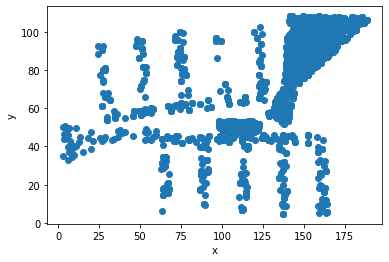

In [3]:
# Let's visualize one of the images to get a feeling of the data that we are handling!
plt.figure()
plt.scatter(train_fireEvac[:, 0], train_fireEvac[:, 1]) 
plt.xlabel("x") 
plt.ylabel("y")
plt.savefig("./task4-traindata-data-vis.jpg")# testi merak ettim, bu yeterli mi kaydetmek icin

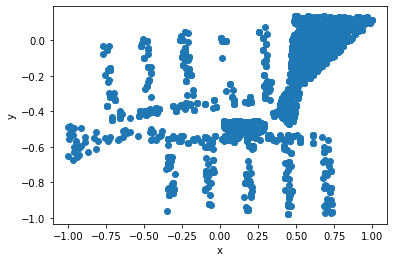

In [4]:
# we want to rescale the data into [-1,1]
to_min = -1.
to_max = 1.
dataset = np.concatenate((train_fireEvac, test_fireEvac))
dataset = preprocess_data(dataset, to_min, to_max)

# split the dataset again  
train_fireEvac = dataset[:3000]  
test_fireEvac = dataset[3001:] 

# visualization after siking
plt.figure()
plt.scatter(train_fireEvac[:, 0], train_fireEvac[:, 1]) 
plt.xlabel("x") 
plt.ylabel("y")
plt.savefig("./task4-traindata-normalized-data-vis.jpg")

Text(0, 0.5, 'y')

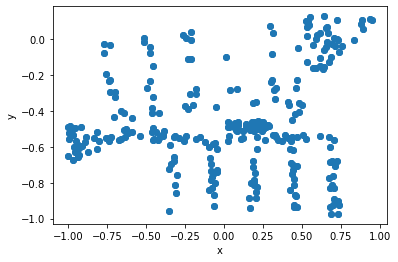

In [5]:
plt.figure()
plt.scatter(test_fireEvac[:, 0], test_fireEvac[:, 1]) 
plt.xlabel("x") 
plt.ylabel("y")

# Shuffle and batch the data

In [6]:
train_size = 3000
test_size = 600
# 128 batch size 
batch_size = 128 

train_dataset = (tf.data.Dataset.from_tensor_slices(train_fireEvac)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_fireEvac)
                .shuffle(test_size).batch(batch_size))
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)>


2022-06-22 17:16:49.041097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 17:16:49.060884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gergedan/.local/repos/ulfm2/4.1.0u1a1-gcc10/lib
2022-06-22 17:16:49.060903: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-22 17:16:49.061427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor

# Define the Optimizer

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-3) # learning rate given as 0.001 in the exercise sheet

# number of epochs to do in total in the training
epochs = 100 

# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2

# Train and plot the latent representations, reconstructions, generations (decode samples from the prior) for each batch iteration

In [8]:
# example reconstructions to generate during the training after each epoch 
#num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement
#random_vector_for_generation = tf.random.normal(
#    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim) 

## Initially plot and save the reconstructions of the test set 

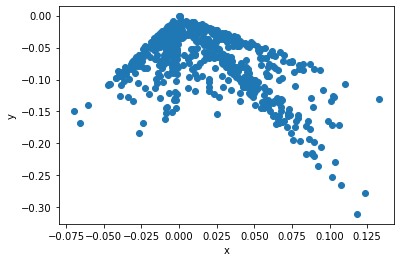

In [9]:
# predict the sample images from the test set with initial weights
reconstruct_and_save_images(model, 0, test_fireEvac) # 0-th epoch 

As one can see, the untrained model produces white-noise when trying to reconstruct the images from the test dataset given above.

## Initially plot and save the generations of 16 images (decoded from the prior)

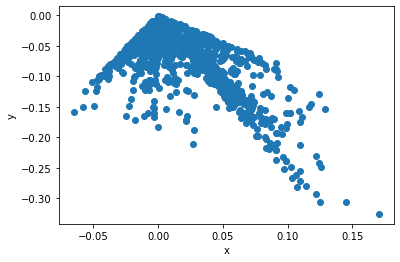

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 0.02323922, -0.05726627],
       [ 0.01491526, -0.01840032],
       [ 0.01689786, -0.0621009 ],
       ...,
       [-0.01525227, -0.04368235],
       [-0.00178613, -0.07237171],
       [-0.00763501, -0.1603874 ]], dtype=float32)>

In [10]:
# Generate random images
generate_and_save_images(model, 0, 1000, latent_dim) 

As one can see, the randomly generated samples as well as the latent space looks like a white-noise on the untrained model. Now we train it and see how these improve over time (number of epochs).

# Training the model (with the 2-dimensional latent space)

Epoch: 100, Test set ELBO: -6.564521789550781, time elapse for current epoch: 0.16602516174316406
Reconstruction of the Test Set


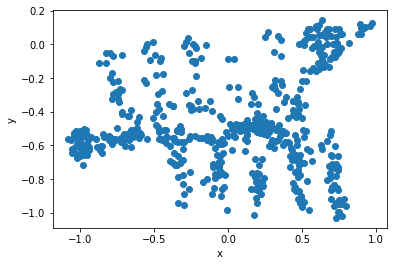

Generation of 1000 samples


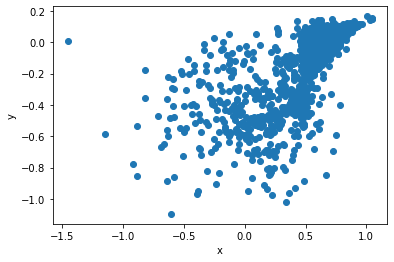

In [11]:
# keep track of the history manually
history_dict = {}
history_dict["train_loss"] = []
history_dict["test_loss"] = []

# Start of the main training loop
for epoch in range(1, epochs + 1):
    # for calcualting the mean loss of the batches 
    train_loss = tf.keras.metrics.Mean()
    
    # time analysis for the current epoch
    start_time = time.time()
    # iterate each batch
    for train_x in train_dataset:
        # do a single training step
        batch_train_loss = train_step(model, train_x, optimizer)
        # save the loss of this batch
        train_loss(batch_train_loss)
    end_time = time.time()
    
    # get the mean loss of the batches
    train_loss_mean = train_loss.result()
    
    # save this mean loss manually to later plot the loss curve
    history_dict["train_loss"].append(train_loss_mean)
    
    # this loss is for the test loss
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        # compute and save the loss for each test batch
        loss(compute_loss(model, test_x))
    
    # get the mean loss of the test batches
    test_loss_mean = loss.result()
    elbo = -test_loss_mean
    
    # save this mean loss again manually to later plot the loss curve for the test loss
    history_dict["test_loss"].append(test_loss_mean)
    
    # clear the current notebook output for nice visualization
    display.clear_output(wait=False)
    
    # print the current epoch and current elbo for the test set
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
        
    print("Reconstruction of the Test Set")
    # plot and save reconstructions of the same images
    reconstruct_and_save_images(model, epoch, test_fireEvac)
    
    print("Generation of 1000 samples")
    # Generate random images (16 images)
    generate_and_save_images(model, epoch, 1000, latent_dim)

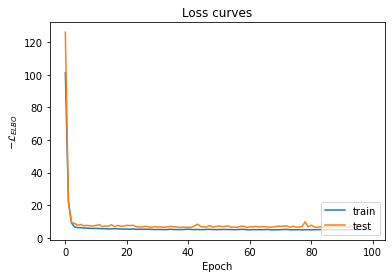

In [12]:
# Plot the train-test loss
plot_and_save_loss_curves(history_dict, epoch) 

# Generate data to estimate the critical number of people for the MI building: how many samples (people) are approximately needed to exceed the critical number at the main entrance (critical number is 100)?

In [13]:
# Orange rectangle in the exercise sheet is the critical area: (130/70 & 150/50)
# we generate sample and check if the number of peds exceeds 100 in this orange area. 
# we gradually increase the generated number of pedestrians each time if this does not exceed.

Generating 10000000 samples:


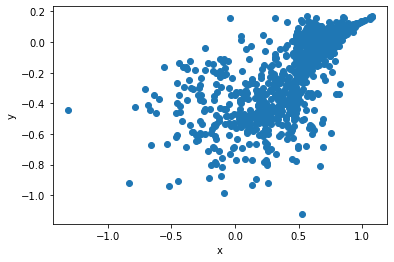

exceeded people number: 9


ValueError: anan

In [29]:
treshold = 1000000000
num_samples = 10000000

# region added and normalized together with the data
region = np.array([[130, 150], [50, 70]]).astype("float32")

concat = np.concatenate((train_fireEvac, test_fireEvac))
concat = np.concatenate((concat, region))
concat = preprocess_data(concat, -1, 1)

region = np.reshape(concat[-2:], (4,))

# run until we exceed the critical number of pedestrian in the critical region
while num_samples < treshold:
    print("Generating", num_samples, "samples:")
    # generate data
    generated_data = generate_and_save_images(model, epoch, num_samples, latent_dim)
    # check if criticial area exceeds 100 people
    exceeds = False
  
    exceeded_people = 0
    for sample in generated_data:
        if sample[0] >= region[0] and sample[0] <= region[1] and sample[1] >= region[2] and sample[1] <= region[3]:
            exceeded_people += 1
    
    exceeds |= exceeded_people > 100

    print("exceeded people number:", exceeded_people)
    
    raise ValueError("anan")
    
    if exceeds:
        print("exceeded at" + str(num_samples) + "ped generation")
        break
        #return num_samples
    
    display.clear_output(wait=False)
    
    num_samples += 1

**NOTE:** We do the same things as above now for the 32 dimensional latent space. We do not repeat the steps for the 32-dimensional latent space since one can restart the notebook and set the 'latent_dim' variable accordingly to get the model with k-dimensional latent space (K << D). But if the latent space has more than 3 dimensions it would be hard to try to visualize them as we did using the latent space visualization in 2D. However we have included the genenrated samples and reconstructions of the 32-dimensional model in the report and discuss the difference with the 2-dimensional one.